In [1]:
from wilcoxon import sheets
import geopandas as gpd
import pandas as pd
import seaborn as sns
import shapely.geometry as gm
import shapely.ops as ops
from wilcoxon.utils import *
from tqdm import tqdm
import numpy as np
import contextily as ctx
import fiona
import matplotlib.pyplot as plt
import ast
import requests
import random
import itertools as it
import json
import os
import math

In [11]:
coords = sheets.getGeo("Malls Coords")
# malls = sheets.getGeo("Malls")
mallsalt = sheets.getGeo("Malls Final")
halal = sheets.getGeo("Halal")
bus = sheets.getGeo("Bus")
mrt = sheets.getGeo("MRT")
# postcode = sheets.getGeo("Postcode")
# schools = sheets.getGeo("Schools")

In [35]:
mrt = sheets.getGeo("MRT")

In [3]:
coordsT = coords.T.reset_index()
coordsT = coordsT.rename(columns={"index":"Name"})
coordsT.Name = coordsT.Name.astype("category")
coordsT.Name.cat.set_categories(mallsalt.Name.tolist(),inplace=True)
coordsT.sort_values(by="Name",inplace=True)

In [26]:
[x for x in mallsalt.Name.tolist() if x not in coordsT.Name.tolist()]

['Leisure Park Kallang',
 'Marina Bay Link Mall',
 'Novena Square',
 'JEM',
 'Changi Airport T3']

In [4]:
shapes = []
for name,*shape in coordsT.values.tolist():
    if name in mallsalt.Name.tolist():
        shape = [tuple([float(y) for y in x.split(", ")[::-1]]) for x in shape if pd.notnull(x)]
        shapes.append(gm.Polygon(shape))
mallsG = gpd.GeoDataFrame(mallsalt,geometry=shapes)

In [5]:
mallsG = gpd.GeoDataFrame(mallsalt)

In [6]:
mallsG.geometry.apply(lambda x: x.exterior.coords.xy).to_clipboard(index=False,header=False)

## Halal

In [7]:
hss = []
for mall, name in tqdm(mallsG[["geometry","Name"]].values.tolist()):
    hs = 0
    ns = []
    for *h, loc, hname in halal[["Longitude","Latitude","Location","Name"]].values.tolist():
        h = gm.Point(h)
        if h.within(mall) or mall.exterior.distance(h)*111.139 < 0.15 or loc==name:
            try:
                d = int(mall.exterior.distance(h)*111139)
            except:
                print(loc, hname)
            if h.within(mall):
                d = 0
            hs += 1
            ns.append(hname + " (" + str(d) + "m)")
    hss.append((hs,", ".join(ns)))

100%|██████████| 101/101 [00:06<00:00, 14.84it/s]


In [9]:
pd.DataFrame(hss)[0].to_clipboard(index=False,header=False)

## Bus

In [12]:
bss = []
for mall in tqdm(mallsG["geometry"].tolist()):
    s = []
    for *b, service in bus[["Longitude","Latitude","ServiceNo"]].values.tolist():
        b = gm.Point(b)
        if b.within(mall) or mall.exterior.distance(b)*111.139 < 0.3:
            s.append(service)
    bss.append((len(set(s)),", ".join(set(s))))

100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


In [13]:
pd.DataFrame(bss)[0].to_clipboard(index=False,header=False)

## MRT

In [49]:
# mrt = sheets.getGeo("MRT")
mrt = mrt[~mrt.Name.str.contains("Ten Mile")]
mrt["Labels"] = mrt.groupby("Name").Label.transform(lambda x: ", ".join(x))

mss = []

for mall in tqdm(mallsG["geometry"].tolist()):
    d = 100000000
    details = ""
    for mx, my, *detail in mrt[["Long","Lat","Label","Abbreviation","Name"]].values.tolist():
        m = gm.Point((mx,my))
        if m.within(mall):
            d = 0
            details = detail
        else:
            distance = mall.exterior.distance(m)*111.139*1000
            if distance < d:
                d = distance
                details = detail
    mss.append((d,*details))

<ipython-input-49-d834e5020f9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrt["Labels"] = mrt.groupby("Name").Label.transform(lambda x: ", ".join(x))
100%|██████████| 101/101 [00:00<00:00, 148.64it/s]


In [50]:
pd.DataFrame(mss).to_clipboard(index=False,header=False)

## Coastline

In [169]:
elevation = gpd.read_file("Documents/Geospatial/GEOSPATIAL/national-map-line/national-map-line-geojson.geojson")
elevation["Location"] = elevation.Description.str.extract("<td>(.*?)</td>")

elevation = elevation[elevation.Location == '0']
elevation["polygon"] = elevation.geometry.apply(lambda x: [gm.Point(y) for y in list(zip(*x.coords.xy))])
elevation = elevation[elevation.polygon.apply(len) > 2]
elevation.loc[:,"geometry"] = elevation.polygon.apply(gm.Polygon)

In [170]:
coastRaw = gpd.read_file("Documents/Geospatial/GEOSPATIAL/national-map-polygon/national-map-polygon-geojson.geojson")
coastRaw["Location"] = coastRaw.Description.str.extract("<td>(.*?)</td>")
coastRaw["Area"] = coastRaw.to_crs(2154).area
coast = coastRaw[coastRaw.Location.isin(["SINGAPORE - MAIN ISLAND","SENTOSA"])]
nonCoast = coastRaw[~coastRaw.Location.isin(["SINGAPORE - MAIN ISLAND","SENTOSA"])]
coastM = ops.unary_union(coastRaw.geometry.tolist())
coastM = ops.unary_union([gm.Polygon(x.exterior) for x in list(coastM)])
water = gpd.read_file("Documents/Geospatial/GEOSPATIAL/sdcp-waterbody/sdcp-waterbody-shp/G_MP08_WATERBODY_PL.shp").to_crs(4326).fillna("")
waterG = ()
for w in water[water.NAME.str.contains("(SUNGEI|RIVER|RESERVOIR|BASIN|POND|LAGOON)")].geometry.tolist():
    if w.type == "MultiPolygon":
        waterG += tuple(list(w))
    else: waterG += (w,)

/Users/izzhafeez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [171]:
coastA = ops.unary_union(coastRaw.geometry.tolist())

for c in tqdm(water.geometry.tolist()):
    try:
        if c.buffer(-10/111139).area > 0:
            coastA = coastA.difference(c.buffer(40/111139))
    except: None
        
coastA = gm.multipolygon.MultiPolygon([gm.Polygon(x.exterior) for x in coastA])

coastF = ops.unary_union(coastRaw.geometry.tolist())

for c in tqdm(water.geometry.tolist()):
    try:
#         if c.buffer(-10/111139).area > 0 and c.intersection(coastA).area == 0:
        coastF = coastF.difference(c)
    except: None

100%|██████████| 955/955 [01:52<00:00,  8.50it/s]


<AxesSubplot:>

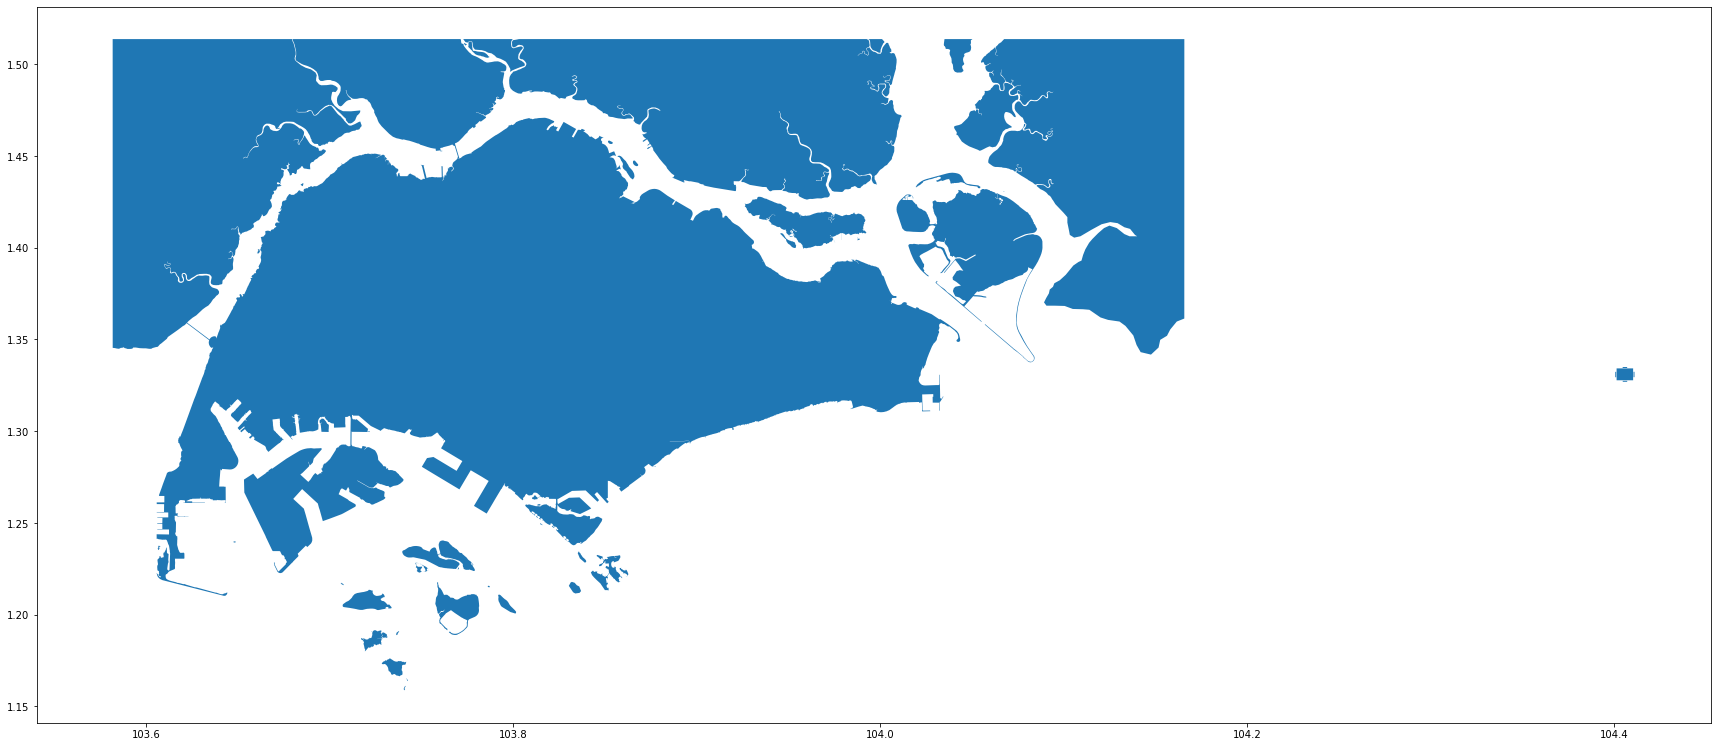

In [174]:
G = ops.unary_union([*coastRaw.geometry.tolist(),*water.geometry.tolist()])
G = gm.multipolygon.MultiPolygon([gm.Polygon(x.exterior) for x in G])

coastG = gpd.GeoDataFrame([G]).T
coastG.columns = ["geometry"]
coastG.plot(figsize=(30,30))

In [183]:
L = []
for mall in tqdm(mallsG.geometry.tolist()):
    approxd = 10000000
    for coord in list(zip(*mall.exterior.coords.xy)):
        dist = G.boundary.distance(gm.Point(coord))*111139
        if dist < approxd:
            approxd = dist
        # for w in waterG:
        #     dist = w.exterior.distance(gm.Point(coord))*111139
        #     if dist < approxd:
        #         approxd = dist
            
            
    # d = approxd + 10
    # while mall.buffer(d / 111139).difference(coast).area > 0:
    #     d -= 0.25
    L.append(approxd)

100%|██████████| 120/120 [00:00<00:00, 320.57it/s]


In [184]:
pd.DataFrame(L).to_clipboard(index=False,header=False)

In [179]:
coastF

## Centroid

In [186]:
mallsG.geometry.centroid.y.to_clipboard(index=False,header=False)

## Postcode

In [ ]:
postcodeB = postcode.drop_duplicates("Building").set_index("Building").to_dict("index")
postcodeP = postcode.drop_duplicates("Postcode").set_index("Postcode").to_dict("index")

In [ ]:
def findCoords(x,y):
    try: return postcodeB[x.upper()]
    except:
        try: return postcodeP[y]
        except: return {'Lat':np.nan,
                       'Long':np.nan}

lat = []
long = []
for h in tqdm(halal[["Location","Postal Code"]].values.tolist()):
    res = findCoords(*h)
    lat.append(res["Lat"])
    long.append(res["Long"])

In [ ]:
pd.DataFrame([lat,long]).T.to_clipboard(index=False,header=False)

In [ ]:
ax = mallsG[mallsG.Name.isin(["Grandstand Car Mall"])].plot(figsize=(15,15))
ctx.add_basemap(ax,crs="EPSG:4326",source=ctx.providers.OneMapSG.Default,zoom=18)

## Residents

In [ ]:
residents = pd.read_csv("Documents/Geospatial/GEOSPATIAL/singapore-residents-by-planning-areasubzone-age-group-sex-and-type-of-dwelling-june-20112020/respopagesextod2011to2020.csv")
residents = residents[residents.Time==2020]
residents.columns = ["Planning","Subzone","Age","Sex","Type","Population","Year"]

In [ ]:
subzones = gpd.read_file("Documents/Geospatial/GEOSPATIAL/master-plan-2019-subzone-boundary-no-sea/master-plan-2019-subzone-boundary-no-sea-geojson.geojson")
subzones["Subzone"] = subzones.Description.str.extract("</td>.*?<td>(.*?)</td>")

In [ ]:
residents.Subzone = residents.Subzone.str.upper()
r2 = residents.merge(subzones, on="Subzone", how="left")
r2["Population"] = r2[r2.Population.apply(lambda x: type(x) == int)].groupby("Subzone").Population.transform(np.nansum)
r2 = r2.drop_duplicates("Subzone")
r2 = gpd.GeoDataFrame(r2)
r2["Density"] = r2.Population / r2.to_crs(2154).area *1000000

In [ ]:
L = []
for mall in mallsG[["Longitude","Latitude"]].values.tolist():
    point = gm.Point(*mall)
    density = r2[r2.geometry.apply(lambda x: x.contains(point))].Density.iloc[0]
    L.append(density)

In [ ]:
pd.DataFrame(L).to_clipboard(index=False,header=False)

## Residents V2

In [ ]:
residents = pd.read_csv("Documents/Geospatial/GEOSPATIAL/population_sgp_2018-10-01.csv")

In [ ]:
L = []
for mall in tqdm(mallsG.geometry.tolist()):
    l = 0
    mdist = 10000000
    for *point, p15, p20 in residents.values.tolist():
        if mall.contains(gm.Point(point[::-1])):
            mdist = 0
            l = p20
        d = mall.exterior.distance(gm.Point(point[::-1]))
        if d < mdist:
            mdist = d
            l = p20
    L.append(l)

In [ ]:
pd.DataFrame(L).to_clipboard(index=False,header=False)

## Buildings

In [ ]:
residents = sheets.getGeo("Postcode")

In [ ]:
L = []
for mall in tqdm(mallsG.geometry.tolist()):
    l = 0
    for point in residents[["Lat","Long"]].values.tolist():
        if mall.contains(gm.Point(point[::-1])):
            l += 1
        elif mall.exterior.distance(gm.Point(point[::-1]))*111.139 < 1:
            l += 1
    L.append(l)

In [ ]:
pd.DataFrame(L).to_clipboard(index=False,header=False)

## Passenger

In [187]:
bustraffic = pd.read_csv("Documents/Geospatial/GEOSPATIAL/origin_destination_bus_202103.csv")
mrttraffic = pd.read_csv("Documents/Geospatial/GEOSPATIAL/origin_destination_train_202103.csv")
busoriginD = bustraffic.groupby("ORIGIN_PT_CODE").TOTAL_TRIPS.sum().to_dict()
busdestinationD = bustraffic.groupby("DESTINATION_PT_CODE").TOTAL_TRIPS.sum().to_dict()
mrtoriginD = mrttraffic.groupby("ORIGIN_PT_CODE").TOTAL_TRIPS.sum().to_dict()
mrtdestinationD = mrttraffic.groupby("DESTINATION_PT_CODE").TOTAL_TRIPS.sum().to_dict()

busD = bus.drop_duplicates("BusStopCode").set_index("BusStopCode")[["Latitude","Longitude"]].to_dict("index")
mrt["Labels"] = mrt.Label.str.split(", ")
mrtD = mrt.explode("Labels").drop_duplicates("Labels").set_index("Labels")[["Lat","Long"]].to_dict("index")

for stop in busD:
    try: busD[stop]["Origin"] = busoriginD[stop]
    except: busD[stop]["Origin"] = 0
    try: busD[stop]["Destination"] = busdestinationD[stop]
    except: busD[stop]["Destination"] = 0
    busD[stop]["Passengers"] = busD[stop]["Origin"] + busD[stop]["Destination"]
    
for stop in mrtD:
    try: mrtD[stop]["Origin"] = mrtoriginD[stop]
    except: mrtD[stop]["Origin"] = 0
    try: mrtD[stop]["Destination"] = mrtdestinationD[stop]
    except: mrtD[stop]["Destination"] = 0
    mrtD[stop]["Passengers"] = mrtD[stop]["Origin"] + mrtD[stop]["Destination"]
    
busG = gpd.GeoDataFrame(busD).T
busG["geometry"] = gpd.points_from_xy(busG.Longitude,busG.Latitude)

mrtG = gpd.GeoDataFrame(mrtD).T
mrtG["geometry"] = gpd.points_from_xy(mrtG.Long,mrtG.Lat)

In [188]:
plane = pd.read_csv("Documents/Geospatial/GEOSPATIAL/civil-aircraft-arrivals-departures-passengers-and-mail-changi-airport-monthly/civil-aircraft-arrivals-departures-and-passengers-changi-airport-monthly.csv")

In [189]:
pss = []
for mall in tqdm(mallsG["geometry"].tolist()):
    b = 0
    t = 0
    for *g, passengers in busG[["Longitude","Latitude","Passengers"]].values.tolist():
        g = gm.Point(g)
        if g.within(mall) or mall.exterior.distance(g)*111.139 < 0.3:
            b += passengers
    for *g, passengers in mrtG[["Long","Lat","Passengers"]].values.tolist():
        g = gm.Point(g)
        if g.within(mall) or mall.exterior.distance(g)*111.139 < 0.3:
            t += passengers
    pss.append((b,t,b+t))

100%|██████████| 120/120 [00:14<00:00,  8.40it/s]


In [190]:
pd.DataFrame(pss).to_clipboard(index=False,header=False)

In [100]:
hs = 0
ns = []
for *h, loc, name in halal[["Longitude","Latitude","Location","Name"]].values.tolist():
    h = gm.Point(h)
    d = dist(h.y,h.x,1.4177200652559196, 103.90123099150395)
    if d < 0.5:
        hs += 1
        ns.append(name + " (" + str(d) + "m)")

## Passenger 2

In [2]:
json.loads(open("Documents/Geospatial/GEOSPATIAL/PassengerVolumeByTrainStations/PassengerVolumeByTrainStations.json").read())

{'odata.metadata': 'http://datamall2.mytransport.sg/ltaodataservice/$metadata#FarecardBatch',
 'value': [{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202001/transport_node_train_202001.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkcwRQIgIlXGcu67IvGqtV2A8ypIzYL2eFMqBAFQNeKtX%2BnAn14CIQDdarYVp5Ny6ME6py8YTxzVWGAqp45QaYolGdgm8fmQ7SqjAwg%2BEAEaDDM0MDY0NTM4MTMwNCIMfy8pXsM9ycKykdE0KoAD3Kp4ANfwBtjLloePcCXLH1vBvGzDzicAqgSbI0X8u85%2FI9uFPAgGDBV7PMiEo3OIytz196gaLglG5vhcca355QqZiAh%2FYIxH%2FnWljcAAg8JEQPwHFHRB1k9wYVbmX7%2BnBBo%2FVW1hMLTz9QRvOolD1caEGqSkK8%2Fa7f5XOIT%2FPy8Z6t%2Fq%2BP2iOeOevP6WGvfokFeCekZnTF6pFKCcO1cKbCdSoACiagiLLvXLpcouZXT%2BziOp8P5H0UlWGdLQ%2BkHTghudqAdc30qVXWTUZVjII90uPO9sM8gYSlh6gyVD6wN6deo%2FOmIesYJ6I6VhS9gkzXJa%2Fpg2ts4cpGjQPDluneMSxbMsH%2BS4PonMgIlqKNPkoQEQOzvlUOERzc6HrGloAPPCsVMbb39omlmHnC2fI3cN8ULQmtb1TebClc%2BtipN65jPLyf7vm6Zd9%2FJ3aZXpTSAKrubjAIKTDQ3piJlSeg%2FQ15hOD1f0B2d0o%2B7SQJBA8fws7bp2m23ElG49eTdCM

## Elevation 2

In [156]:
def randomPoint(poly,npoly=""):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = gm.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p

In [157]:
randomPoints2 = []
for g in mallsG.geometry.tolist():
#     gb = g.buffer(2/111139)
    randomPoints2.append("|".join([",".join([str(x[0]) for x in randomPoint(g).coords.xy[::-1]]) for i in range(4)]))
    randomPoints2.append("|".join([",".join([str(x[0]) for x in randomPoint(g).coords.xy[::-1]]) for i in range(4)]))
    randomPoints2.append("|".join([",".join([str(x[0]) for x in randomPoint(g).coords.xy[::-1]]) for i in range(4)]))
    randomPoints2.append("|".join([",".join([str(x[0]) for x in randomPoint(g).coords.xy[::-1]]) for i in range(4)]))

In [159]:
responses = []
for points in tqdm(randomPoints2):
    responses.append(requests.get(f"https://api.opentopodata.org/v1/test-dataset?locations={points}").text)

100%|██████████| 480/480 [03:02<00:00,  2.63it/s]


In [160]:
L = []
for response in responses:
    try: L.append(np.mean([r["elevation"] for r in ast.literal_eval(response)["results"]]))
    except: L.append(np.nan)

In [172]:
pd.DataFrame([np.nanmax(L[i*4:4+i*4]) for i in range(120)]).to_clipboard(index=False,header=False)

## Town Council

In [31]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
planning = gpd.read_file('Documents/Geospatial/GEOSPATIAL/subzone-census-2010/Subzone_Census2010.kml', driver='KML')
# planning = gpd.read_file('./Geospatial/GEOSPATIAL/subzone-census-2010/Subzone_Census2010.kml', driver='KML')
planning["SubzoneCode"] = planning.Description.str.extract("Subzone Code.*?<td>(.*?)</td>")
planning["Planning"] = planning.Description.str.extract("Planning Area Name.*?<td>(.*?)</td>")
planning["PlanningCode"] = planning.Description.str.extract("Planning Area Code.*?<td>(.*?)</td>")
planning["Region"] = planning.Description.str.extract("Region Name.*?<td>(.*?)</td>")
planning["RegionCode"] = planning.Description.str.extract("Region Code.*?<td>(.*?)</td>")
planning = planning.rename(columns={"Name":"Subzone"})
planning = planning.drop("Description",axis=1)
planning = planning[['Region', 'RegionCode', 'Planning', 'PlanningCode', 'Subzone', 'SubzoneCode', 'geometry']]

In [32]:
plans = []
for lat,long in mallsG[["Latitude","Longitude"]].values.tolist():
    point = gm.Point(long,lat)
    planfull = ""
    planabbr = ""
    for full,abbr,geometry in planning[["Planning","PlanningCode","geometry"]].values.tolist():
        if point.within(geometry):
            planfull = full
            planabbr = abbr
    plans.append((planfull,planabbr))

In [51]:
pd.DataFrame(plans).to_clipboard(index=False,header=False)

## Schools

In [20]:
schools["Latitude"] = schools.Coords.apply(lambda x: float(ast.literal_eval(x)[0]))
schools["Longitude"] = schools.Coords.apply(lambda x: float(ast.literal_eval(x)[1]))

In [27]:
sss = []
for mall in tqdm(mallsG["geometry"].tolist()):
    ss = []
    for *s, name in schools[["Longitude","Latitude","Name"]].values.tolist():
        s = gm.Point(s)
        if s.within(mall) or mall.exterior.distance(s)*111.139 < 3:
            ss.append(name)
    sss.append((len(set(ss)),", ".join(set(ss))))

100%|██████████| 100/100 [00:01<00:00, 95.84it/s]


In [30]:
pd.DataFrame(sss)[1].to_clipboard(header=False,index=False)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

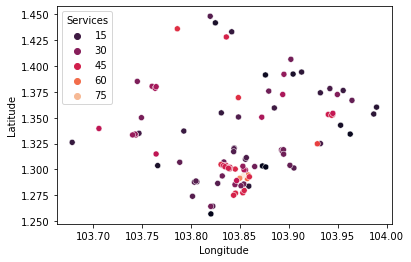

In [122]:
sns.scatterplot(x=mallsalt.Longitude,y=mallsalt.Latitude,hue=mallsalt.Services,palette="rocket")

In [111]:
m = mallsalt[mallsalt.columns[28:55]].replace("#N/A (RANK has no valid input data.)","0").applymap(lambda x: float(x))
mdict = {}
for col in m.columns:
    mdict[col] = [np.nanmean(m[col].tolist()) if x == 0 else x for x in m[col].tolist()]

In [116]:
results = []
for combi in it.combinations(mdict.keys(),2):
    results.append((*combi, np.corrcoef(mdict[combi[0]],mdict[combi[1]])[1,0]))

## Metric

In [29]:
metricRaw = pd.read_clipboard()

In [34]:
metricRaw.T.values.tolist()

[[100,
  98,
  25,
  23,
  99,
  95,
  42,
  43,
  15,
  97,
  22,
  60,
  36,
  80,
  96,
  74,
  77,
  18,
  28,
  90,
  85,
  4,
  12,
  26,
  94,
  66,
  5,
  14,
  61,
  87,
  6,
  8,
  93,
  17,
  54,
  63,
  21,
  3,
  16,
  72,
  38,
  40,
  7,
  55,
  44,
  88,
  24,
  29,
  69,
  10,
  76,
  56,
  45,
  81,
  11,
  65,
  33,
  84,
  37,
  2,
  13,
  92,
  83,
  50,
  39,
  35,
  71,
  1,
  59,
  32,
  73,
  91,
  48,
  9,
  78,
  20,
  62,
  41,
  49,
  34,
  57,
  75,
  70,
  58,
  19,
  30,
  64,
  27,
  52,
  68,
  79,
  47,
  31,
  53,
  89,
  46,
  86,
  82,
  51,
  67],
 [78,
  77,
  87,
  1,
  79,
  47,
  96,
  100,
  11,
  83,
  3,
  68,
  99,
  36,
  53,
  61,
  54,
  14,
  2,
  44,
  37,
  59,
  92,
  73,
  42,
  32,
  65,
  91,
  71,
  81,
  20,
  19,
  35,
  29,
  38,
  21,
  51,
  86,
  5,
  17,
  94,
  4,
  16,
  39,
  13,
  82,
  28,
  12,
  30,
  31,
  41,
  69,
  15,
  45,
  95,
  88,
  33,
  49,
  84,
  76,
  89,
  48,
  34,
  26,
  97,
  6,
  60,
  80,
  74

In [95]:
dist(1.25664485,103.82041896,1.255516067282589, 103.81956789493094)*math.tan(37.6891047*math.pi/180)*1000

121.47228759573129

In [45]:
math.tan(90*math.pi/90)

-1.2246467991473532e-16

In [49]:
math.tan(math.pi/4)

0.9999999999999999

In [91]:
mm = pd.read_clipboard()

In [92]:
L = []
for m in mm.T.values.tolist():
    try:
        L.append(dist(*[float(x.strip()) for x in m[0].split(",")],*[float(x.strip()) for x in m[1].split(",")])*math.tan((float(m[2])-90)*math.pi/180)*1000)
    except Exception as e:
        L.append(float(m[4]))

In [94]:
pd.DataFrame(L).to_clipboard(index=False,header=False)